In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns 
import pydotplus
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

## Tratamento de dados

In [2]:
dfs = pd.read_html('https://www.worldfootball.net/schedule/bra-serie-a-2020-spieltag/1/', header = 0)
df = dfs[3]
for i in range(2,39):
    dfs = pd.read_html(f'https://www.worldfootball.net/schedule/bra-serie-a-2020-spieltag/{i}/', header = 0)
    df = pd.concat([df,dfs[3]])

In [3]:
df.drop(['Team'], inplace=True, axis=1)
df.rename(index=str, columns={'#': 'Posicao', 'Team.1': 'Time', 'M.': 'Rodada_atual', 'W': 'Vitorias',
                              'D': 'Empates', 'L': 'Derrotas', 'goals': 'Gols',
                               'Dif.': 'Saldo_gols', 'Pt.': 'Pontuacao'}, inplace=True)
df['Posicao'] = pd.to_numeric(df.index) + 1

Atributo: ranking dos clubes 2020

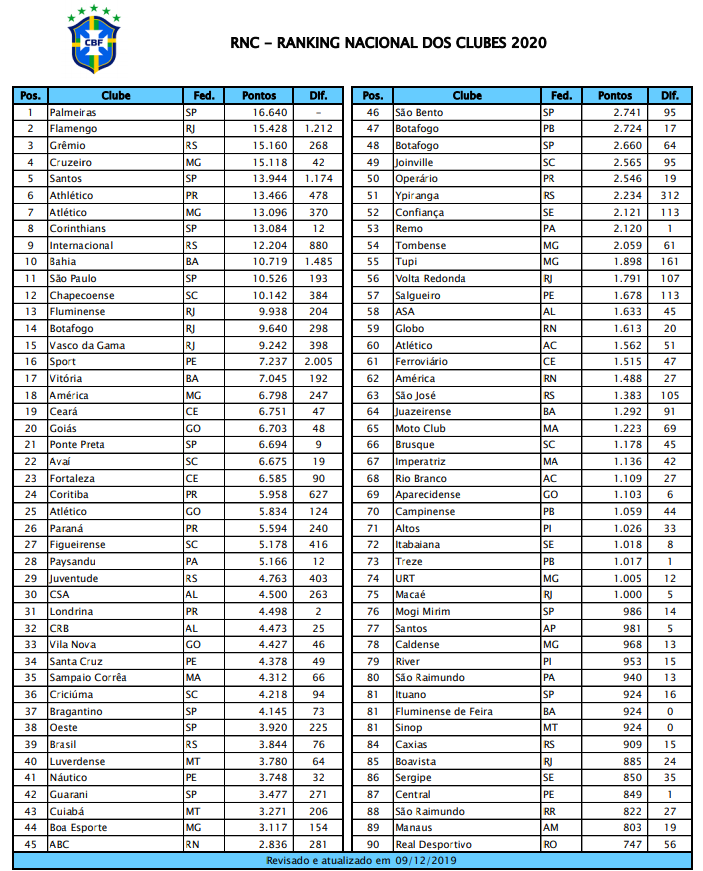

In [4]:
# ranking de clubes da cbf em 2020
df['Ranking_2020'] = 0
df.loc[df['Time']=='São Paulo FC','Ranking_2020'] = 10526
df.loc[df['Time']=='Sport - PE','Ranking_2020'] = 7237
df.loc[df['Time']=='Bahia - BA','Ranking_2020'] = 10719
df.loc[df['Time']=='Atlético Mineiro','Ranking_2020'] = 13096
df.loc[df['Time']=='Grêmio Porto Alegre','Ranking_2020'] = 15160
df.loc[df['Time']=='Santos FC','Ranking_2020'] = 13944
df.loc[df['Time']=='Internacional','Ranking_2020'] = 12204
df.loc[df['Time']=='Athletico Paranaense','Ranking_2020'] = 13466
df.loc[df['Time']=='Vasco da Gama','Ranking_2020'] = 9242
df.loc[df['Time']=='Atlético Goianiense','Ranking_2020'] = 5834
df.loc[df['Time']=='Corinthians SP','Ranking_2020'] = 13084
df.loc[df['Time']=='Red Bull Bragantino','Ranking_2020'] = 4145 
df.loc[df['Time']=='Ceará - CE','Ranking_2020'] = 6751
df.loc[df['Time']=='Botafogo - RJ','Ranking_2020'] = 9640
df.loc[df['Time']=='Coritiba FC','Ranking_2020'] = 5958
df.loc[df['Time']=='Flamengo RJ','Ranking_2020'] = 15428
df.loc[df['Time']=='Fluminense RJ','Ranking_2020'] = 9938
df.loc[df['Time']=='Fortaleza','Ranking_2020'] = 6585
df.loc[df['Time']=='Goiás','Ranking_2020'] = 6703
df.loc[df['Time']=='Palmeiras','Ranking_2020'] = 16640

Atributo: Valor do elenco do time

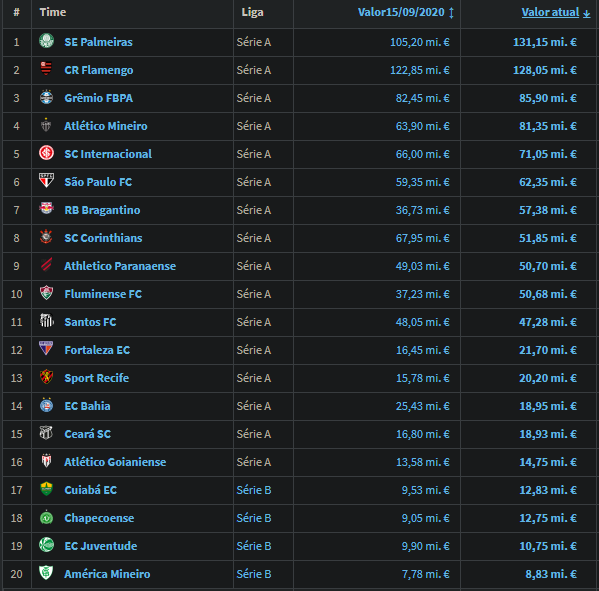

In [5]:
# valor do time em 15/09/20 - transfermarkt
df['Valor_time_mi'] = 0
df.loc[df['Time']=='São Paulo FC','Valor_time_mi'] = 59.35
df.loc[df['Time']=='Sport - PE','Valor_time_mi'] = 15.78
df.loc[df['Time']=='Bahia - BA','Valor_time_mi'] = 25.45
df.loc[df['Time']=='Atlético Mineiro','Valor_time_mi'] = 63.9
df.loc[df['Time']=='Grêmio Porto Alegre','Valor_time_mi'] = 82.45
df.loc[df['Time']=='Santos FC','Valor_time_mi'] = 48.05
df.loc[df['Time']=='Internacional','Valor_time_mi'] = 66
df.loc[df['Time']=='Athletico Paranaense','Valor_time_mi'] = 49.03
df.loc[df['Time']=='Vasco da Gama','Valor_time_mi'] = 27
df.loc[df['Time']=='Atlético Goianiense','Valor_time_mi'] = 13.58
df.loc[df['Time']=='Corinthians SP','Valor_time_mi'] = 67.95
df.loc[df['Time']=='Red Bull Bragantino','Valor_time_mi'] = 36.73
df.loc[df['Time']=='Ceará - CE','Valor_time_mi'] = 16.8
df.loc[df['Time']=='Botafogo - RJ','Valor_time_mi'] = 16.78
df.loc[df['Time']=='Coritiba FC','Valor_time_mi'] = 14.5
df.loc[df['Time']=='Flamengo RJ','Valor_time_mi'] = 122.85
df.loc[df['Time']=='Fluminense RJ','Valor_time_mi'] = 37.23
df.loc[df['Time']=='Fortaleza','Valor_time_mi'] = 16.45
df.loc[df['Time']=='Goiás','Valor_time_mi'] = 7.8
df.loc[df['Time']=='Palmeiras','Valor_time_mi'] = 105.2

In [6]:
aux = df['Gols'].str.split(':', n = 1, expand = True)
df['Gols_marcados'] = aux[0] 
df['Gols_sofridos'] = aux[1] 
df = df.drop(columns=['Gols'])

Atributo: taxa de gols

In [7]:
taxa_gols = []
aux1 = df['Gols_marcados'].values
aux2 = df['Gols_sofridos'].values
linhas = df.shape[0]
for i in range(0,linhas):
    if int(aux2[i]) != 0:
        divisao = int(aux1[i])/int(aux2[i])
    else:
        divisao = 1
    divisao = np.round(divisao,3)
    taxa_gols.append(divisao)
df = df.assign(Taxa_gols = taxa_gols)

Atributo: aproveitamento

In [8]:
aproveitamento = []
linhas = df.shape[0]
aux1 = df['Pontuacao'].values
pont_max = df['Rodada_atual'].values*3
for i in range(0,linhas):
    aproveitamento.append(aux1[i]/pont_max[i])
df = df.assign(Aproveitamento = aproveitamento)

Atributo: ranking historico

In [9]:
ranking_h = pd.read_html('https://pt.wikipedia.org/wiki/Campeonato_Brasileiro_de_Futebol', header = 1)

In [10]:
ranking_hist = ranking_h[10]
ranking_hist.drop(['Unnamed: 10'], inplace=True, axis=1)
ranking_hist.rename(index=str, columns={'Clubes.1': 'Time'}, inplace=True)

In [11]:
def ranking (time):
    x = ranking_hist.loc[ranking_hist['Time']==time,'Pts']
    return int(x)

In [12]:
df.loc[df['Time']=='São Paulo FC','Ranking_hist'] = ranking('São Paulo')
df.loc[df['Time']=='Sport - PE','Ranking_hist'] = ranking('Sport')
df.loc[df['Time']=='Bahia - BA','Ranking_hist'] = ranking('Bahia')
df.loc[df['Time']=='Atlético Mineiro','Ranking_hist'] = ranking('Atlético Mineiro')
df.loc[df['Time']=='Grêmio Porto Alegre','Ranking_hist'] = ranking('Grêmio')
df.loc[df['Time']=='Santos FC','Ranking_hist'] = ranking('Santos')
df.loc[df['Time']=='Internacional','Ranking_hist'] = ranking('Internacional')
df.loc[df['Time']=='Athletico Paranaense','Ranking_hist'] = ranking('Athletico Paranaense')
df.loc[df['Time']=='Vasco da Gama','Ranking_hist'] = ranking('Vasco da Gama')
df.loc[df['Time']=='Atlético Goianiense','Ranking_hist'] = 74*3+76
df.loc[df['Time']=='Corinthians SP','Ranking_hist'] = ranking('Corinthians')
df.loc[df['Time']=='Red Bull Bragantino','Ranking_hist'] = 82*3 + 92
df.loc[df['Time']=='Ceará - CE','Ranking_hist'] = 149*3+151
df.loc[df['Time']=='Botafogo - RJ','Ranking_hist'] = ranking('Botafogo')
df.loc[df['Time']=='Coritiba FC','Ranking_hist'] = ranking('Coritiba')
df.loc[df['Time']=='Flamengo RJ','Ranking_hist'] = ranking('Flamengo')
df.loc[df['Time']=='Fluminense RJ','Ranking_hist'] = ranking('Fluminense')
df.loc[df['Time']=='Fortaleza','Ranking_hist'] = 123*3 + 123
df.loc[df['Time']=='Goiás','Ranking_hist'] = ranking('Goiás')
df.loc[df['Time']=='Palmeiras','Ranking_hist'] = ranking('Palmeiras')

Atributo: jogando em casa

In [13]:
dfs2 = pd.read_html('https://www.worldfootball.net/schedule/bra-serie-a-2020-spieltag/1/heim/', header = 0)
df2 = dfs2[2]
for i in range(2,39):
    dfs2 = pd.read_html(f'https://www.worldfootball.net/schedule/bra-serie-a-2020-spieltag/{i}/heim/', header = 0)
    df2 = pd.concat([df2,dfs2[2]])

In [14]:
df2.drop(['Team'], inplace=True, axis=1)
df2.rename(index=str, columns={'#': 'Posicao', 'Team.1': 'Time', 'M.': 'Rodada_atual', 'W': 'Vitorias',
                              'D': 'Empates', 'L': 'Derrotas', 'goals': 'Gols',
                               'Dif.': 'Saldo_gols', 'Pt.': 'Pontuacao'}, inplace=True)

In [15]:
def jogando_casa(time):
    aux1 = []
    aux2 = []
    for index, linha in df2.iterrows():
        if linha['Time'] == time:
            aux1.append(linha['Rodada_atual'])
    for i in range(len(aux1)):
        if i == 0:
            aux2.append(aux1[i])
        else:
            aux2.append(aux1[i]-aux1[i-1])
    return aux2

In [16]:
df.loc[df['Time']=='São Paulo FC','Jogando_casa'] = [i for i in jogando_casa('São Paulo FC')]
df.loc[df['Time']=='Sport - PE','Jogando_casa'] = [i for i in jogando_casa('Sport - PE')]
df.loc[df['Time']=='Bahia - BA','Jogando_casa'] = [i for i in jogando_casa('Bahia - BA')]
df.loc[df['Time']=='Atlético Mineiro','Jogando_casa'] = [i for i in jogando_casa('Atlético Mineiro')]
df.loc[df['Time']=='Grêmio Porto Alegre','Jogando_casa'] = [i for i in jogando_casa('Grêmio Porto Alegre')]
df.loc[df['Time']=='Santos FC','Jogando_casa'] = [i for i in jogando_casa('Santos FC')]
df.loc[df['Time']=='Internacional','Jogando_casa'] = [i for i in jogando_casa('Internacional')]
df.loc[df['Time']=='Athletico Paranaense','Jogando_casa'] = [i for i in jogando_casa('Athletico Paranaense')]
df.loc[df['Time']=='Vasco da Gama','Jogando_casa'] = [i for i in jogando_casa('Vasco da Gama')]
df.loc[df['Time']=='Atlético Goianiense','Jogando_casa'] = [i for i in jogando_casa('Atlético Goianiense')]
df.loc[df['Time']=='Corinthians SP','Jogando_casa'] = [i for i in jogando_casa('Corinthians SP')]
df.loc[df['Time']=='Red Bull Bragantino','Jogando_casa'] = [i for i in jogando_casa('Red Bull Bragantino')]
df.loc[df['Time']=='Ceará - CE','Jogando_casa'] = [i for i in jogando_casa('Ceará - CE')]
df.loc[df['Time']=='Botafogo - RJ','Jogando_casa'] = [i for i in jogando_casa('Botafogo - RJ')]
df.loc[df['Time']=='Coritiba FC','Jogando_casa'] = [i for i in jogando_casa('Coritiba FC')]
df.loc[df['Time']=='Flamengo RJ','Jogando_casa'] = [i for i in jogando_casa('Flamengo RJ')]
df.loc[df['Time']=='Fluminense RJ','Jogando_casa'] = [i for i in jogando_casa('Fluminense RJ')]
df.loc[df['Time']=='Fortaleza','Jogando_casa'] = [i for i in jogando_casa('Fortaleza')]
df.loc[df['Time']=='Goiás','Jogando_casa'] = [i for i in jogando_casa('Goiás')]
df.loc[df['Time']=='Palmeiras','Jogando_casa'] = [i for i in jogando_casa('Palmeiras')]

In [17]:
# def vitorias(time):
#     aux1 = []
#     aux2 = []
#     for index, linha in df.iterrows():
#         if linha['Time'] == time:
#             aux1.append(linha.Vitorias)
#     for i in range(len(aux1)):
#         if i == 0:
#             aux2.append(aux1[i])
#         else:
#             aux2.append(aux1[i]-aux1[i-1])
#     return aux2

In [18]:
# df.loc[df['Time']=='São Paulo FC','Classe'] = [i for i in vitorias('São Paulo FC')]
# df.loc[df['Time']=='Sport - PE','Classe'] = [i for i in vitorias('Sport - PE')]
# df.loc[df['Time']=='Bahia - BA','Classe'] = [i for i in vitorias('Bahia - BA')]
# df.loc[df['Time']=='Atlético Mineiro','Classe'] = [i for i in vitorias('Atlético Mineiro')]
# df.loc[df['Time']=='Grêmio Porto Alegre','Classe'] = [i for i in vitorias('Grêmio Porto Alegre')]
# df.loc[df['Time']=='Santos FC','Classe'] = [i for i in vitorias('Santos FC')]
# df.loc[df['Time']=='Internacional','Classe'] = [i for i in vitorias('Internacional')]
# df.loc[df['Time']=='Athletico Paranaense','Classe'] = [i for i in vitorias('Athletico Paranaense')]
# df.loc[df['Time']=='Vasco da Gama','Classe'] = [i for i in vitorias('Vasco da Gama')]
# df.loc[df['Time']=='Atlético Goianiense','Classe'] = [i for i in vitorias('Atlético Goianiense')]
# df.loc[df['Time']=='Corinthians SP','Classe'] = [i for i in vitorias('Corinthians SP')]
# df.loc[df['Time']=='Red Bull Bragantino','Classe'] = [i for i in vitorias('Red Bull Bragantino')]
# df.loc[df['Time']=='Ceará - CE','Classe'] = [i for i in vitorias('Ceará - CE')]
# df.loc[df['Time']=='Botafogo - RJ','Classe'] = [i for i in vitorias('Botafogo - RJ')]
# df.loc[df['Time']=='Coritiba FC','Classe'] = [i for i in vitorias('Coritiba FC')]
# df.loc[df['Time']=='Flamengo RJ','Classe'] = [i for i in vitorias('Flamengo RJ')]
# df.loc[df['Time']=='Fluminense RJ','Classe'] = [i for i in vitorias('Fluminense RJ')]
# df.loc[df['Time']=='Fortaleza','Classe'] = [i for i in vitorias('Fortaleza')]
# df.loc[df['Time']=='Goiás','Classe'] = [i for i in vitorias('Goiás')]
# df.loc[df['Time']=='Palmeiras','Classe'] = [i for i in vitorias('Palmeiras')]

In [19]:
df['Gols_marcados'] = df['Gols_marcados'].astype(int)
df['Gols_sofridos'] = df['Gols_sofridos'].astype(int)
# df['Classe'] = df['Classe'].astype(int)

TABELA FINAL

In [20]:
df

,Posicao,Time,Rodada_atual,Vitorias,Empates,Derrotas,Saldo_gols,Pontuacao,Ranking_2020,Valor_time_mi,Gols_marcados,Gols_sofridos,Taxa_gols,Aproveitamento,Ranking_hist,Jogando_casa
0,1,São Paulo FC,1,1,0,0,3,3,10526,59.35,3,0,1.000,1.000000,2214.0,0.0
1,2,Sport - PE,1,1,0,0,1,3,7237,15.78,3,2,1.500,1.000000,1123.0,1.0
2,3,Bahia - BA,1,1,0,0,1,3,10719,25.45,2,1,2.000,1.000000,1254.0,0.0
3,4,Atlético Mineiro,1,1,0,0,1,3,13096,63.90,1,0,1.000,1.000000,2084.0,0.0
4,5,Grêmio Porto Alegre,1,1,0,0,1,3,15160,82.45,1,0,1.000,1.000000,2112.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,Fortaleza,38,10,11,17,-10,41,6585,16.45,34,44,0.773,0.359649,492.0,0.0
16,17,Vasco da Gama,38,10,11,17,-19,41,9242,27.00,37,56,0.661,0.359649,1807.0,1.0
17,18,Goiás,38,9,10,19,-22,37,6703,7.80,41,63,0.651,0.324561,1344.0,0.0
18,19,Coritiba FC,38,7,10,21,-23,31,5958,14.50,31,54,0.574,0.271930,1279.0,0.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760 entries, 0 to 19
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Posicao         760 non-null    int64  
 1   Time            760 non-null    object 
 2   Rodada_atual    760 non-null    int64  
 3   Vitorias        760 non-null    int64  
 4   Empates         760 non-null    int64  
 5   Derrotas        760 non-null    int64  
 6   Saldo_gols      760 non-null    int64  
 7   Pontuacao       760 non-null    int64  
 8   Ranking_2020    760 non-null    int64  
 9   Valor_time_mi   760 non-null    float64
 10  Gols_marcados   760 non-null    int32  
 11  Gols_sofridos   760 non-null    int32  
 12  Taxa_gols       760 non-null    float64
 13  Aproveitamento  760 non-null    float64
 14  Ranking_hist    760 non-null    float64
 15  Jogando_casa    760 non-null    float64
dtypes: float64(5), int32(2), int64(8), object(1)
memory usage: 95.0+ KB


In [22]:
df.describe()

,Posicao,Rodada_atual,Vitorias,Empates,Derrotas,Saldo_gols,Pontuacao,Ranking_2020,Valor_time_mi,Gols_marcados,Gols_sofridos,Taxa_gols,Aproveitamento,Ranking_hist,Jogando_casa
count,760.000000,760.000000,760.000000,760.000000,760.000000,760.00000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000,760.000000
mean,10.500000,19.500000,6.864474,5.771053,6.864474,0.00000,26.364474,10315.000000,44.644000,23.888158,23.888158,1.080567,0.450018,1531.200000,0.500000
std,5.770079,10.973078,4.782357,3.705596,4.872152,9.65437,16.814262,3607.333514,31.673493,15.443957,14.860151,0.535995,0.159528,642.339906,0.500329
min,1.000000,1.000000,0.000000,0.000000,0.000000,-30.00000,0.000000,4145.000000,7.800000,0.000000,0.000000,0.000000,0.000000,298.000000,0.000000
25%,5.750000,10.000000,3.000000,3.000000,3.000000,-5.00000,12.000000,6739.000000,16.697500,12.000000,11.000000,0.729250,0.354513,1221.250000,0.000000
50%,10.500000,19.500000,6.000000,6.000000,6.000000,0.00000,24.000000,10232.000000,36.980000,22.000000,24.000000,1.000000,0.437798,1754.500000,0.500000
75%,15.250000,29.000000,10.000000,9.000000,10.000000,5.00000,38.000000,13188.500000,64.425000,34.000000,35.250000,1.333000,0.555556,2090.750000,1.000000
max,20.000000,38.000000,21.000000,17.000000,21.000000,27.00000,71.000000,16640.000000,122.850000,68.000000,63.000000,5.000000,1.000000,2214.000000,1.000000


## Machine Learning

Método Kbest - identificar os melhores atributos

In [23]:
def select_kbest_clf(data_frame, target, k='all'):
    feat_selector = SelectKBest(f_classif, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["Atributo"] = data_frame.drop(target, axis=1).columns
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["Valor p"] = feat_selector.pvalues_
    
    return feat_scores
df_aux = df.drop(['Time','Posicao'],1)
kbest_feat = select_kbest_clf(df_aux, 'Pontuacao', k='all')
kbest_feat = kbest_feat.sort_values(["F Score", "Valor p"], ascending=[False, False])
kbest_feat

,Atributo,F Score,Valor p
1,Vitorias,396.755392,0.000000e+00
7,Gols_marcados,193.745769,0.000000e+00
0,Rodada_atual,56.667576,2.031556e-240
8,Gols_sofridos,17.991498,3.741591e-114
2,Empates,17.281230,1.691875e-110
4,Saldo_gols,8.100192,9.883626e-54
3,Derrotas,7.798703,1.669466e-51
10,Aproveitamento,6.878880,1.513155e-44
6,Valor_time_mi,2.942836,7.308469e-13
9,Taxa_gols,2.424379,7.116916e-09


In [24]:
pontuacao = df['Pontuacao']
atributos = df.drop(['Time','Pontuacao','Vitorias','Empates','Rodada_atual','Derrotas','Posicao'],1)

Correlação de Pearson

In [25]:
corr = df.drop(['Time'],1).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,Posicao,Rodada_atual,Vitorias,Empates,Derrotas,Saldo_gols,Pontuacao,Ranking_2020,Valor_time_mi,Gols_marcados,Gols_sofridos,Taxa_gols,Aproveitamento,Ranking_hist,Jogando_casa
Posicao,1.000,0.000,-0.484,0.019,0.460,-0.837,-0.409,-0.588,-0.637,-0.321,0.210,-0.767,-0.876,-0.538,-0.038
Rodada_atual,0.000,1.000,0.824,0.834,0.809,0.000,0.887,0.000,-0.000,0.898,0.934,-0.070,0.007,0.000,0.000
Vitorias,-0.484,0.824,1.000,0.594,0.423,0.507,0.984,0.287,0.334,0.951,0.659,0.276,0.395,0.264,0.013
Empates,0.019,0.834,0.594,1.000,0.535,0.043,0.727,0.014,0.051,0.728,0.729,-0.042,-0.029,-0.028,0.002
Derrotas,0.460,0.809,0.423,0.535,1.000,-0.531,0.479,-0.292,-0.367,0.536,0.902,-0.397,-0.349,-0.239,-0.015
Saldo_gols,-0.837,0.000,0.507,0.043,-0.531,1.000,0.442,0.473,0.604,0.372,-0.263,0.640,0.647,0.418,0.023
Pontuacao,-0.409,0.887,0.984,0.727,0.479,0.442,1.000,0.248,0.296,0.972,0.723,0.226,0.330,0.220,0.012
Ranking_2020,-0.588,0.000,0.287,0.014,-0.292,0.473,0.248,1.000,0.847,0.189,-0.111,0.372,0.483,0.828,0.000
Valor_time_mi,-0.637,-0.000,0.334,0.051,-0.367,0.604,0.296,0.847,1.000,0.243,-0.140,0.413,0.511,0.665,-0.000
Gols_marcados,-0.321,0.898,0.951,0.728,0.536,0.372,0.972,0.189,0.243,1.000,0.798,0.165,0.252,0.192,0.007


In [26]:
#scaler = MinMaxScaler().fit(atributos)
#atrib_norm = scaler.transform(atributos)
scaler = StandardScaler()
atrib_norm = scaler.fit_transform(atributos)
atrib_norm=pd.DataFrame(atrib_norm)
atrib_norm.columns = atributos.columns

In [27]:
atrib_norm

,Saldo_gols,Ranking_2020,Valor_time_mi,Gols_marcados,Gols_sofridos,Taxa_gols,Aproveitamento,Ranking_hist,Jogando_casa
0,0.310945,0.058530,0.464606,-1.353404,-1.608590,-0.150412,3.449833,1.063689,-1.0
1,0.103648,-0.853824,-0.911898,-1.353404,-1.473913,0.783047,3.449833,-0.635908,1.0
2,0.103648,0.112068,-0.606395,-1.418197,-1.541252,1.716506,3.449833,-0.431831,-1.0
3,0.103648,0.771437,0.608354,-1.482990,-1.608590,-0.150412,3.449833,0.861170,-1.0
4,0.103648,1.343982,1.194402,-1.482990,-1.608590,-0.150412,3.449833,0.904790,1.0
...,...,...,...,...,...,...,...,...,...
755,-1.036483,-1.034686,-0.890731,0.655175,1.354299,-0.574203,-0.566848,-1.618900,-1.0
756,-1.969317,-0.297646,-0.557426,0.849554,2.162359,-0.783297,-0.566848,0.429650,1.0
757,-2.280262,-1.001953,-1.164010,1.108726,2.633728,-0.801966,-0.786940,-0.291626,-1.0
758,-2.383910,-1.208613,-0.952337,0.460797,2.027683,-0.945719,-1.117079,-0.392886,-1.0


Regressão Linear

In [28]:
prop_test = 0.3
X_train, X_test, d_train, d_test= train_test_split(atrib_norm,pontuacao, test_size = prop_test,shuffle = True)
model_reg_linear = LinearRegression()
model_reg_linear.fit(X_train,d_train)

LinearRegression()

In [29]:
#Calculando a acurácia do treinamento
y_hat_train = model_reg_linear.predict(X_train)
r2 = r2_score(d_train, y_hat_train)
RSME = np.sqrt(mean_squared_error(d_train, y_hat_train))
print(f'R²: {r2:.2}')
print(f'RSME: {RSME:.2}')

R²: 0.96
RSME: 3.5


In [30]:
#Calculando a acurácia do teste
y_hat_test = model_reg_linear.predict(X_test)
r2 = r2_score(d_test, y_hat_test)
RSME = np.sqrt(mean_squared_error(d_test, y_hat_test))
print(f'R²: {r2:.2}')
print(f'RSME: {RSME:.2}')

R²: 0.96
RSME: 3.5


,Score
Gols_marcados,9.127014
Gols_sofridos,6.293104
Saldo_gols,4.913913
Ranking_2020,1.921595
Aproveitamento,1.320351
Jogando_casa,0.145267
Taxa_gols,-0.276122
Valor_time_mi,-0.745578
Ranking_hist,-1.247668


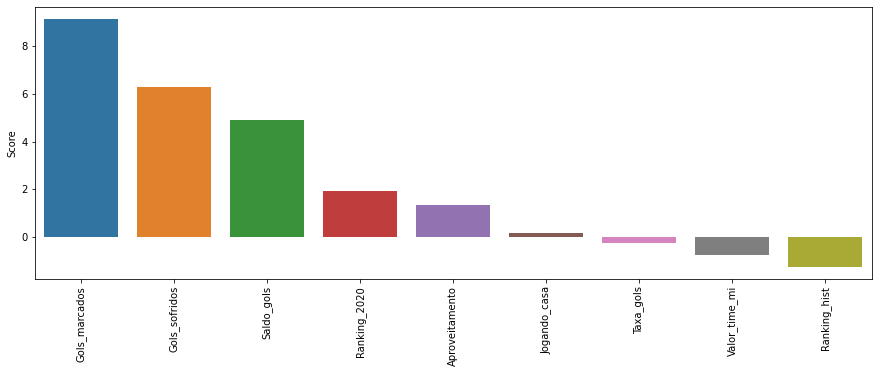

In [31]:
importancia = model_reg_linear.coef_[:]
importancia_features = pd.DataFrame(importancia, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
importancia_features.columns = ['Score']
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features['Score'])
ax.tick_params(axis='x', rotation=90)

Árvore de decisão

In [32]:
prop_test = 0.3
X_train, X_test, d_train, d_test= train_test_split(atrib_norm,pontuacao, test_size = prop_test, shuffle = True)
arvore = DecisionTreeRegressor()
arvore.fit(X_train, d_train)

DecisionTreeRegressor()

In [33]:
#Calculando a acurácia do teste
y_hat_test = arvore.predict(X_test)
r2 = r2_score(d_test, y_hat_test)
RSME = np.sqrt(mean_squared_error(d_test, y_hat_test))
print(f'R²: {r2:.2}')
print(f'RSME: {RSME:.2}')

R²: 0.98
RSME: 2.6


,Score
Gols_marcados,0.948883
Aproveitamento,0.024101
Valor_time_mi,0.008845
Ranking_hist,0.006204
Saldo_gols,0.004649
Taxa_gols,0.003743
Gols_sofridos,0.001650
Ranking_2020,0.001541
Jogando_casa,0.000385


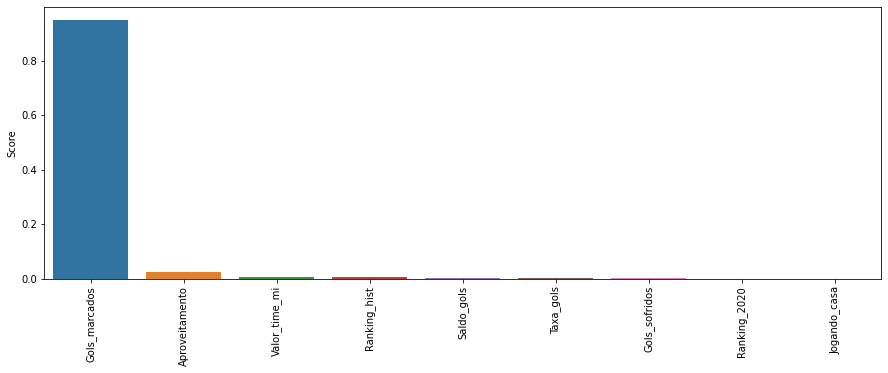

In [34]:
importancia = arvore.feature_importances_
importancia_features = pd.DataFrame(importancia, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
importancia_features.columns = ['Score']
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features['Score'])
ax.tick_params(axis='x', rotation=90)

Random Forest

In [35]:
prop_test = 0.3
X_train, X_test, d_train, d_test= train_test_split(atrib_norm,pontuacao, test_size = prop_test,shuffle = True)
floresta = RandomForestRegressor(n_estimators = 100)
floresta.fit(X_train, d_train)

RandomForestRegressor()

In [36]:
#Calculando a acurácia do teste
y_hat_test = floresta.predict(X_test)
r2 = r2_score(d_test, y_hat_test)
RSME = np.sqrt(mean_squared_error(d_test, y_hat_test))
print(f'R²: {r2:.2}')
print(f'RSME: {RSME:.2}')

R²: 0.99
RSME: 1.9


,Score
Gols_marcados,0.943457
Aproveitamento,0.027520
Valor_time_mi,0.008559
Saldo_gols,0.005979
Ranking_hist,0.004093
Gols_sofridos,0.003625
Taxa_gols,0.003184
Ranking_2020,0.003080
Jogando_casa,0.000503


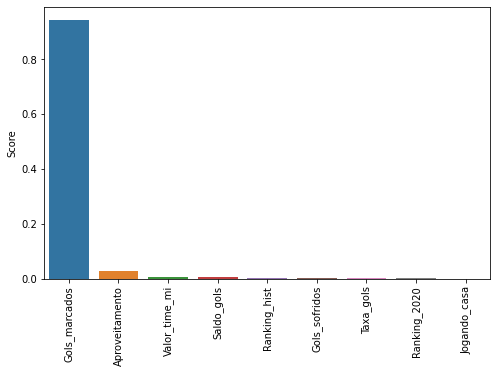

In [37]:
importancia = floresta.feature_importances_
importancia_features = pd.DataFrame(importancia, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
importancia_features.columns = ['Score']
display(importancia_features)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features['Score'])
ax.tick_params(axis='x', rotation=90)

XGBoost

In [38]:
prop_test = 0.3
X_train, X_test, d_train, d_test= train_test_split(atrib_norm,pontuacao, test_size = prop_test,shuffle = True)
model_XGBR = XGBRegressor()
model_XGBR.fit(X_train, d_train,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
#Calculando a acurácia do teste
y_hat_test = model_XGBR.predict(X_test)
r2 = r2_score(d_test, y_hat_test)
RSME = np.sqrt(mean_squared_error(d_test, y_hat_test))
print(f'R²: {r2:.2}')
print(f'RSME: {RSME:.2}')

R²: 0.99
RSME: 1.5


In [40]:
def rodada(numero):
    rodada = df.loc[df['Rodada_atual']==numero]
    rodada = rodada.drop(['Time','Pontuacao','Vitorias','Empates','Rodada_atual','Derrotas','Posicao'],1)
    scaler = StandardScaler()
    rodada_norm = scaler.fit_transform(rodada)
    rodada_norm=pd.DataFrame(rodada_norm)
    rodada_norm.columns = rodada.columns
    return rodada_norm

In [41]:
def times_x(numero):
    times = df.loc[df['Rodada_atual']==numero,'Time']
    times = pd.DataFrame(times)
    times.rename(columns={0: 'Time'}, inplace=True)
    return times
times = times_x(25)

In [42]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html(index=False).replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

Tabela final - Regressão linear

In [43]:
y_pred = model_reg_linear.predict(rodada(25))
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_rl = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_rl['index'] = np.arange(1,21)
pred_table_rl.columns = ['Posicao', 'Time', 'Pontos']

Tabela final - Árvore de decisão

In [44]:
y_pred = arvore.predict(rodada(25))
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_arvore = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_arvore['index'] = np.arange(1,21)
pred_table_arvore.columns = ['Posicao', 'Time', 'Pontos']

Tabela final - Random Forest

In [45]:
y_pred = floresta.predict(rodada(25))
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_floresta = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_floresta['index'] = np.arange(1,21)
pred_table_floresta.columns = ['Posicao', 'Time', 'Pontos']

Tabela final - XGBoost

In [46]:
y_pred = model_XGBR.predict(rodada(25))
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_XGBR = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_XGBR['index'] = np.arange(1,21)
pred_table_XGBR.columns = ['Posicao', 'Time', 'Pontos']

In [47]:
display_side_by_side(pred_table_rl,pred_table_arvore,pred_table_floresta,pred_table_XGBR, titles=['Regressao Linear','Arvore de decisao','Random Forest','XGBoost'])

Posicao,Time,Pontos
1,Flamengo RJ,55.0
2,Atlético Mineiro,49.0
3,Santos FC,39.0
4,São Paulo FC,38.0
5,Ceará - CE,37.0
6,Palmeiras,34.0
7,Internacional,33.0
8,Bahia - BA,31.0
9,Fluminense RJ,31.0
10,Grêmio Porto Alegre,28.0


# Fazendo previsão brasileirão 2021

In [48]:
df_2021_aux = pd.read_html('https://www.worldfootball.net/schedule/bra-serie-a-2021-spieltag/3/', header = 0)
df_2021 = df_2021_aux[3]

In [49]:
df_2021.drop(['Team'], inplace=True, axis=1)
df_2021.rename(index=str, columns={'#': 'Posicao', 'Team.1': 'Time', 'M.': 'Rodada_atual', 'W': 'Vitorias',
                              'D': 'Empates', 'L': 'Derrotas', 'goals': 'Gols',
                               'Dif.': 'Saldo_gols', 'Pt.': 'Pontuacao'}, inplace=True)
df_2021['Posicao'] = pd.to_numeric(df_2021.index) + 1

In [50]:
df_2021['Ranking_2021'] = 0
df_2021.loc[df_2021['Time']=='São Paulo FC','Ranking_2021'] = 11870
df_2021.loc[df_2021['Time']=='Sport - PE','Ranking_2021'] = 7043
df_2021.loc[df_2021['Time']=='Bahia - BA','Ranking_2021'] = 10175
df_2021.loc[df_2021['Time']=='Atlético Mineiro','Ranking_2021'] = 11789
df_2021.loc[df_2021['Time']=='Grêmio Porto Alegre','Ranking_2021'] = 15180
df_2021.loc[df_2021['Time']=='Santos FC','Ranking_2021'] = 12776
df_2021.loc[df_2021['Time']=='Internacional','Ranking_2021'] = 13310
df_2021.loc[df_2021['Time']=='Athletico Paranaense','Ranking_2021'] = 12968
df_2021.loc[df_2021['Time']=='Atlético Goianiense','Ranking_2021'] = 7310
df_2021.loc[df_2021['Time']=='Corinthians SP','Ranking_2021'] = 12032
df_2021.loc[df_2021['Time']=='Red Bull Bragantino','Ranking_2021'] = 6332 
df_2021.loc[df_2021['Time']=='Ceará - CE','Ranking_2021'] = 9128
df_2021.loc[df_2021['Time']=='Flamengo RJ','Ranking_2021'] = 16768
df_2021.loc[df_2021['Time']=='Fluminense RJ','Ranking_2021'] = 9666
df_2021.loc[df_2021['Time']=='Fortaleza','Ranking_2021'] = 8086
df_2021.loc[df_2021['Time']=='Palmeiras','Ranking_2021'] = 16110
df_2021.loc[df_2021['Time']=='Juventude - RS','Ranking_2021'] = 5725
df_2021.loc[df_2021['Time']=='Cuiabá - MT','Ranking_2021'] = 5679
df_2021.loc[df_2021['Time']=='América - MG','Ranking_2021'] = 8404
df_2021.loc[df_2021['Time']=='Chapecoense','Ranking_2021'] = 8985

In [51]:
df_2021['Valor_time_mi'] = 0
df_2021.loc[df_2021['Time']=='São Paulo FC','Valor_time_mi'] = 78.3
df_2021.loc[df_2021['Time']=='Sport - PE','Valor_time_mi'] = 20.5
df_2021.loc[df_2021['Time']=='Bahia - BA','Valor_time_mi'] = 21.93
df_2021.loc[df_2021['Time']=='Atlético Mineiro','Valor_time_mi'] = 85.65
df_2021.loc[df_2021['Time']=='Grêmio Porto Alegre','Valor_time_mi'] = 95.75
df_2021.loc[df_2021['Time']=='Santos FC','Valor_time_mi'] = 69.98
df_2021.loc[df_2021['Time']=='Internacional','Valor_time_mi'] = 69.85
df_2021.loc[df_2021['Time']=='Athletico Paranaense','Valor_time_mi'] = 54.7
df_2021.loc[df_2021['Time']=='Juventude - RS','Valor_time_mi'] = 13.5
df_2021.loc[df_2021['Time']=='Atlético Goianiense','Valor_time_mi'] = 14.98
df_2021.loc[df_2021['Time']=='Corinthians SP','Valor_time_mi'] = 56.05
df_2021.loc[df_2021['Time']=='Red Bull Bragantino','Valor_time_mi'] = 61.03
df_2021.loc[df_2021['Time']=='Ceará - CE','Valor_time_mi'] = 18.7
df_2021.loc[df_2021['Time']=='Chapecoense','Valor_time_mi'] = 15.03
df_2021.loc[df_2021['Time']=='Cuiabá - MT','Valor_time_mi'] = 16.1
df_2021.loc[df_2021['Time']=='Flamengo RJ','Valor_time_mi'] = 152.95
df_2021.loc[df_2021['Time']=='Fluminense RJ','Valor_time_mi'] = 74.68
df_2021.loc[df_2021['Time']=='Fortaleza','Valor_time_mi'] = 21.98
df_2021.loc[df_2021['Time']=='América - MG','Valor_time_mi'] = 12.9
df_2021.loc[df_2021['Time']=='Palmeiras','Valor_time_mi'] = 147.85

In [52]:
aux = df_2021['Gols'].str.split(':', n = 1, expand = True)
df_2021['Gols_marcados'] = aux[0] 
df_2021['Gols_sofridos'] = aux[1] 
df_2021 = df_2021.drop(columns=['Gols'])

In [53]:
taxa_gols = []
aux1 = df_2021['Gols_marcados'].values
aux2 = df_2021['Gols_sofridos'].values
linhas = df_2021.shape[0]
for i in range(0,linhas):
    if int(aux2[i]) != 0:
        divisao = int(aux1[i])/int(aux2[i])
    else:
        divisao = 1
    divisao = np.round(divisao,3)
    taxa_gols.append(divisao)
df_2021 = df_2021.assign(Taxa_gols = taxa_gols)

In [54]:
aproveitamento = []
linhas = df_2021.shape[0]
aux1 = df_2021['Pontuacao'].values
pont_max = df_2021['Rodada_atual'].values*3
for i in range(0,linhas):
    aproveitamento.append(aux1[i]/pont_max[i])
df_2021 = df_2021.assign(Aproveitamento = aproveitamento)

In [55]:
df_2021.loc[df_2021['Time']=='São Paulo FC','Ranking_hist'] = ranking('São Paulo')
df_2021.loc[df_2021['Time']=='Sport - PE','Ranking_hist'] = ranking('Sport')
df_2021.loc[df_2021['Time']=='Bahia - BA','Ranking_hist'] = ranking('Bahia')
df_2021.loc[df_2021['Time']=='Atlético Mineiro','Ranking_hist'] = ranking('Atlético Mineiro')
df_2021.loc[df_2021['Time']=='Grêmio Porto Alegre','Ranking_hist'] = ranking('Grêmio')
df_2021.loc[df_2021['Time']=='Santos FC','Ranking_hist'] = ranking('Santos')
df_2021.loc[df_2021['Time']=='Internacional','Ranking_hist'] = ranking('Internacional')
df_2021.loc[df_2021['Time']=='Athletico Paranaense','Ranking_hist'] = ranking('Athletico Paranaense')
df_2021.loc[df_2021['Time']=='Atlético Goianiense','Ranking_hist'] = 74*3+76
df_2021.loc[df_2021['Time']=='Corinthians SP','Ranking_hist'] = ranking('Corinthians')
df_2021.loc[df_2021['Time']=='Red Bull Bragantino','Ranking_hist'] = 82*3 + 92
df_2021.loc[df_2021['Time']=='Ceará - CE','Ranking_hist'] = 149*3+151
df_2021.loc[df_2021['Time']=='Flamengo RJ','Ranking_hist'] = ranking('Flamengo')
df_2021.loc[df_2021['Time']=='Fluminense RJ','Ranking_hist'] = ranking('Fluminense')
df_2021.loc[df_2021['Time']=='Fortaleza','Ranking_hist'] = 123*3 + 123
df_2021.loc[df_2021['Time']=='Palmeiras','Ranking_hist'] = ranking('Palmeiras')
df_2021.loc[df_2021['Time']=='Cuiabá - MT','Ranking_hist'] = 0
df_2021.loc[df_2021['Time']=='América - MG','Ranking_hist'] = 580
df_2021.loc[df_2021['Time']=='Chapecoense','Ranking_hist'] = 272
df_2021.loc[df_2021['Time']=='Juventude - RS','Ranking_hist'] = 583

In [56]:
df_2021.loc[df_2021['Time']=='São Paulo FC','Jogando_casa'] = 0 
df_2021.loc[df_2021['Time']=='Sport - PE','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Bahia - BA','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Atlético Mineiro','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Grêmio Porto Alegre','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Santos FC','Jogando_casa'] = 1 
df_2021.loc[df_2021['Time']=='Internacional','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Athletico Paranaense','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Cuiabá - MT','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Atlético Goianiense','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Corinthians SP','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Red Bull Bragantino','Jogando_casa'] = 1 
df_2021.loc[df_2021['Time']=='Ceará - CE','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='América - MG','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Chapecoense','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Flamengo RJ','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Fluminense RJ','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Fortaleza','Jogando_casa'] = 1
df_2021.loc[df_2021['Time']=='Juventude - RS','Jogando_casa'] = 0
df_2021.loc[df_2021['Time']=='Palmeiras','Jogando_casa'] = 1

In [57]:
df_2021['Gols_marcados'] = df_2021['Gols_marcados'].astype(int)
df_2021['Gols_sofridos'] = df_2021['Gols_sofridos'].astype(int)

In [58]:
df_2021

,Posicao,Time,Rodada_atual,Vitorias,Empates,Derrotas,Saldo_gols,Pontuacao,Ranking_2021,Valor_time_mi,Gols_marcados,Gols_sofridos,Taxa_gols,Aproveitamento,Ranking_hist,Jogando_casa
0,1,Fortaleza,3,3,0,0,6,9,8086,21.98,8,2,4.000,1.000000,492.0,1.0
1,2,Athletico Paranaense,3,3,0,0,5,9,12968,54.70,5,0,1.000,1.000000,1563.0,0.0
2,3,Atlético Goianiense,2,2,0,0,3,6,7310,14.98,3,0,1.000,1.000000,298.0,0.0
3,4,Flamengo RJ,2,2,0,0,3,6,16768,152.95,3,0,1.000,1.000000,2088.0,1.0
4,5,Atlético Mineiro,3,2,0,1,1,6,11789,85.65,3,2,1.500,0.666667,2084.0,1.0
5,6,Red Bull Bragantino,3,1,2,0,3,5,6332,61.03,8,5,1.600,0.555556,338.0,1.0
6,7,Fluminense RJ,3,1,2,0,1,5,9666,74.68,3,2,1.500,0.555556,1870.0,0.0
7,8,Bahia - BA,3,1,1,1,2,4,10175,21.93,6,4,1.500,0.444444,1254.0,1.0
8,9,Palmeiras,3,1,1,1,1,4,16110,147.85,4,3,1.333,0.444444,2081.0,1.0
9,10,Corinthians SP,3,1,1,1,0,4,12032,56.05,2,2,1.000,0.444444,2099.0,0.0


In [59]:
df_2021_aux = df_2021.drop(['Time','Pontuacao','Vitorias','Empates','Rodada_atual','Derrotas','Posicao'],1)
df_2021_norm = scaler.fit_transform(df_2021_aux)
df_2021_norm=pd.DataFrame(df_2021_norm)
df_2021_norm.columns = df_2021_aux.columns
times = df_2021['Time']
times = pd.DataFrame(times)
times.rename(columns={0: 'Time'}, inplace=True)

In [60]:
y_pred = model_reg_linear.predict(df_2021_norm)
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_rl = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_rl['index'] = np.arange(1,21)
pred_table_rl.columns = ['Posicao', 'Time', 'Pontos']

Tabela final - Árvore de decisão

In [61]:
y_pred = arvore.predict(df_2021_norm)
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_arvore = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_arvore['index'] = np.arange(1,21)
pred_table_arvore.columns = ['Posicao', 'Time', 'Pontos']

Tabela final - Random Forest

In [62]:
y_pred = floresta.predict(df_2021_norm)
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_floresta = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_floresta['index'] = np.arange(1,21)
pred_table_floresta.columns = ['Posicao', 'Time', 'Pontos']

Tabela final - XGBoost

In [63]:
y_pred = model_XGBR.predict(df_2021_norm)
y_pred = pd.DataFrame(np.round(y_pred,0))
pred_table_XGBR = pd.concat([times.reset_index(), y_pred.reset_index()], axis=1).drop(['index'], axis=1).sort_values(0, ascending=False).reset_index()
pred_table_XGBR['index'] = np.arange(1,21)
pred_table_XGBR.columns = ['Posicao', 'Time', 'Pontos']

In [64]:
display_side_by_side(pred_table_rl,pred_table_arvore,pred_table_floresta,pred_table_XGBR, titles=['Regressao Linear','Arvore de decisao','Random Forest','XGBoost'])

Posicao,Time,Pontos
1,Red Bull Bragantino,57.0
2,Fortaleza,54.0
3,Bahia - BA,44.0
4,Internacional,37.0
5,Ceará - CE,35.0
6,Athletico Paranaense,34.0
7,Palmeiras,31.0
8,Santos FC,26.0
9,Atlético Mineiro,23.0
10,Flamengo RJ,23.0
